# Introduction

This project focuses on reconstructing missing daily weather measurements using a neural network–based time-series modelling approach. The dataset contains forty years of multivariate daily weather data from a European city, including variables such as temperature, radiation, precipitation, and pressure. Three decades are available in both corrupted (with missing values) and complete forms, which allows supervised training. I use these decades to train a model that learns the temporal dynamics and inter-variable relationships in the data. The trained architecture is then applied to a fourth decade, for which only corrupted data is available, in order to recover the missing measurements. In essence, the task is a multivariate time-series imputation problem, where the goal is to build a model that can generalise across decades and accurately reconstruct incomplete sequential data.

## Step 1: Data Loading and Exploratory Visualisation

In this step, I loaded all training datasets, including both the corrupted and corresponding uncorrupted versions for the three available decades, as well as the corrupted test dataset. After loading the data, I verified file integrity, column consistency, and chronological ordering to ensure that the datasets were correctly aligned and suitable for time-series analysis.

To investigate the temporal structure and assess the impact of corruption, I selected one decade from the training data and plotted the first 365 days of observations. For each weather variable, I generated an independent line plot to clearly visualise its daily evolution. Each variable was displayed in a separate axis window with appropriately scaled limits to ensure that both seasonal trends and missing-value patterns were clearly observable. I produced these plots for both the original (uncorrupted) and corrupted versions of the same decade to allow direct comparison.

Subsequently, I analysed the statistical distributions of all variables across the full set of training decades. For each weather variable, I plotted histograms before and after corruption. This enabled me to evaluate how the corruption process altered the empirical distributions and to determine whether it introduced structural bias, distributional shifts, or simply random missingness.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1) Line plots for decade 0**

In this case, I choose train_set_0 to visualise data.

In [4]:
import pandas as pd
# load dataset

df0 = pd.read_csv('/content/drive/MyDrive/DL_HW2/training_set/training_set_0.csv')
df0_nogaps = pd.read_csv('/content/drive/MyDrive/DL_HW2/training_set/training_set_0_nogaps.csv')
df1 = pd.read_csv('/content/drive/MyDrive/DL_HW2/training_set/training_set_1.csv')
df1_nogaps = pd.read_csv('/content/drive/MyDrive/DL_HW2/training_set/training_set_1_nogaps.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DL_HW2/training_set/training_set_2.csv')
df2_nogaps = pd.read_csv('/content/drive/MyDrive/DL_HW2/training_set/training_set_2_nogaps.csv')
df_test = pd.read_csv('/content/drive/MyDrive/DL_HW2/test_set.csv')

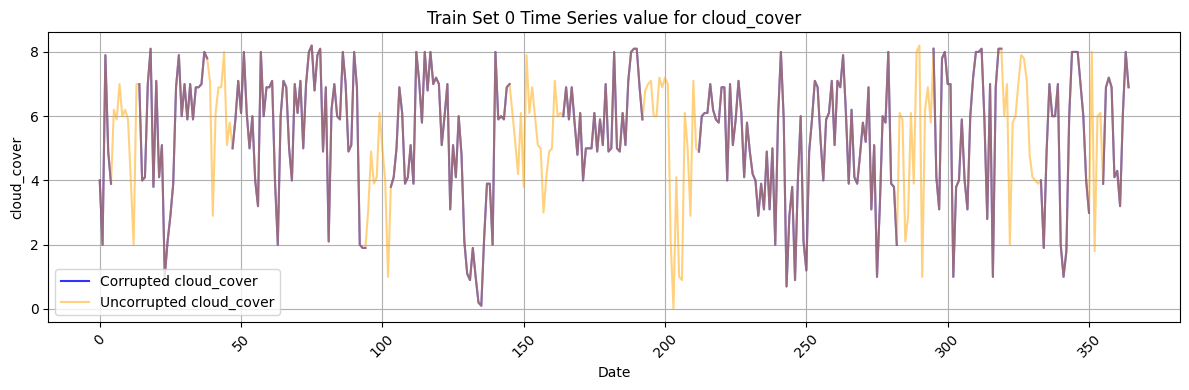

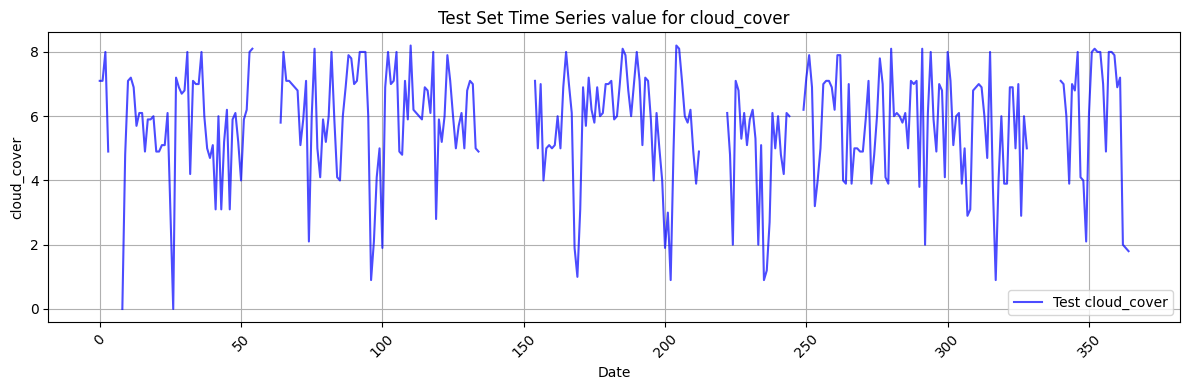

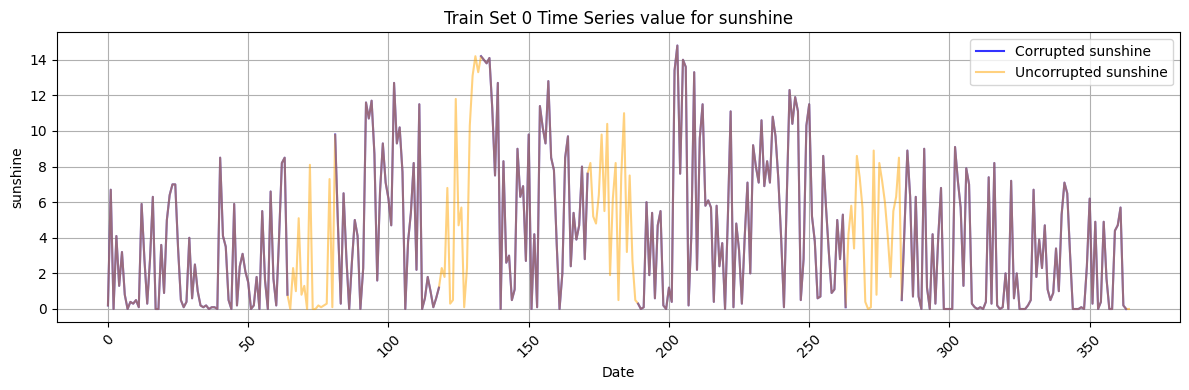

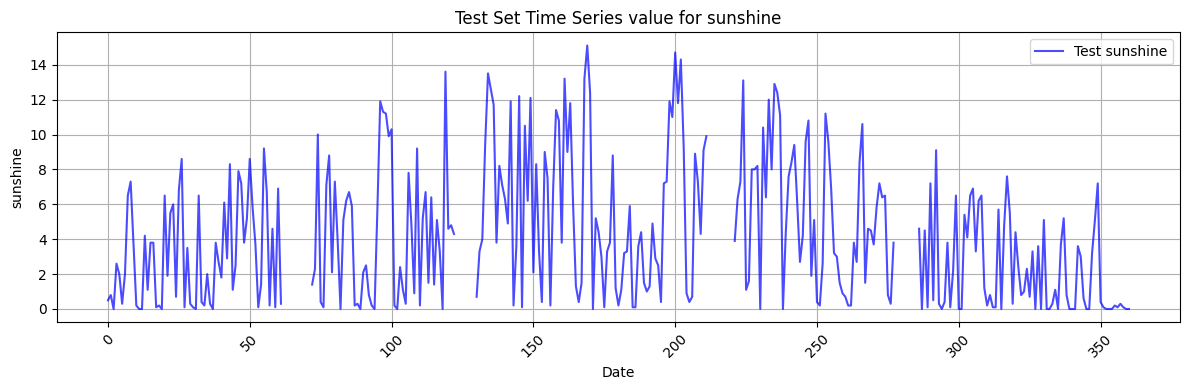

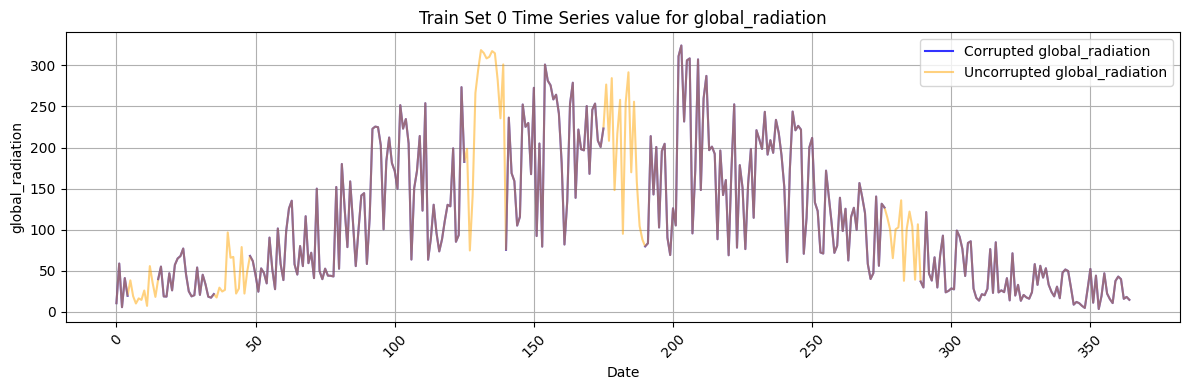

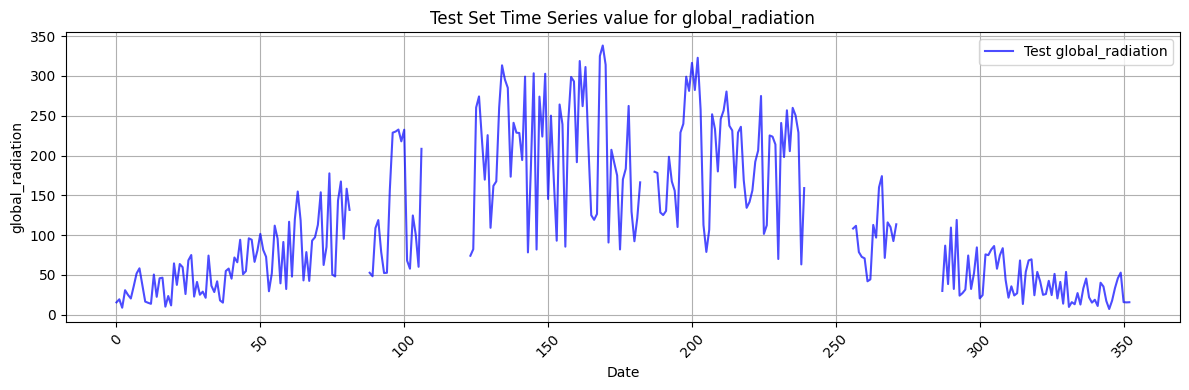

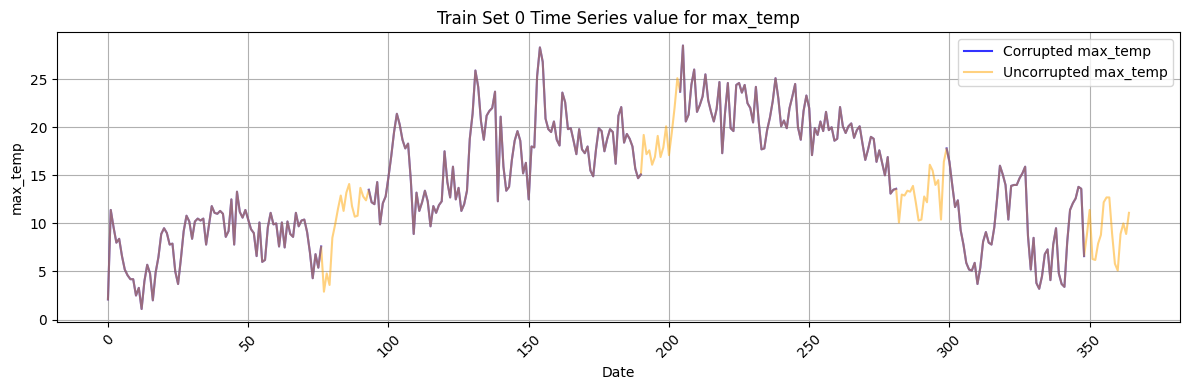

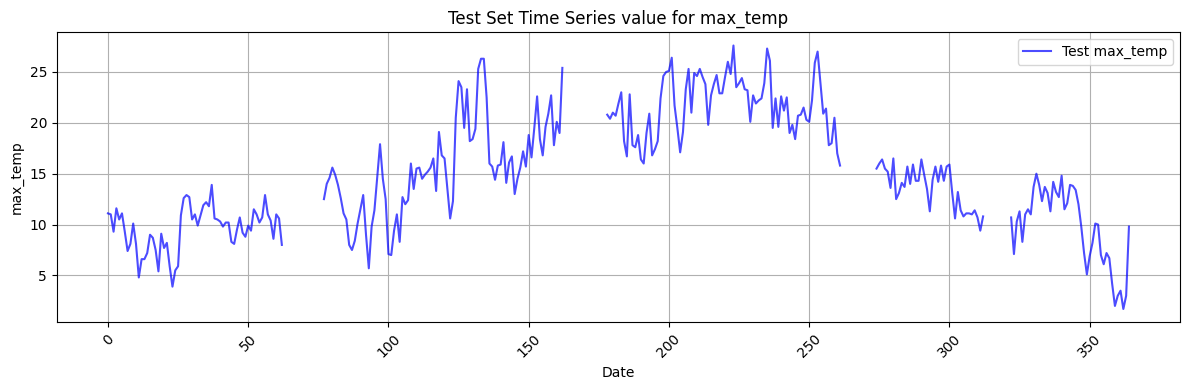

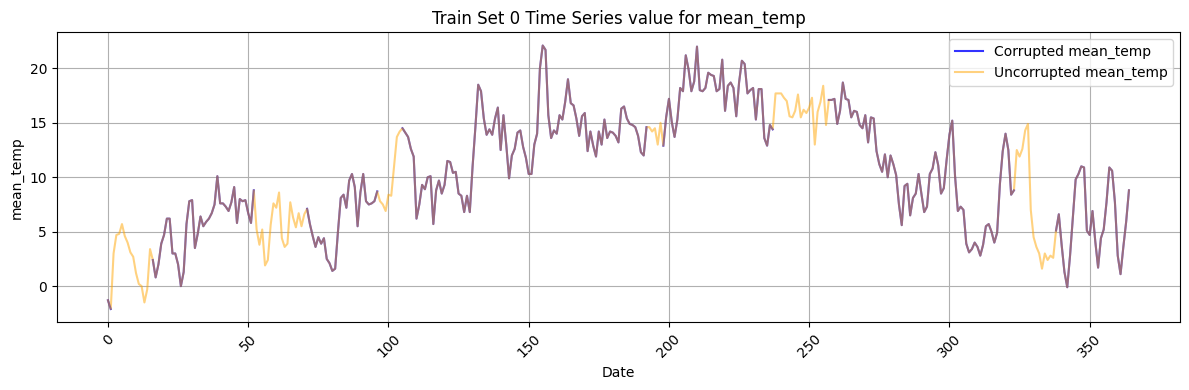

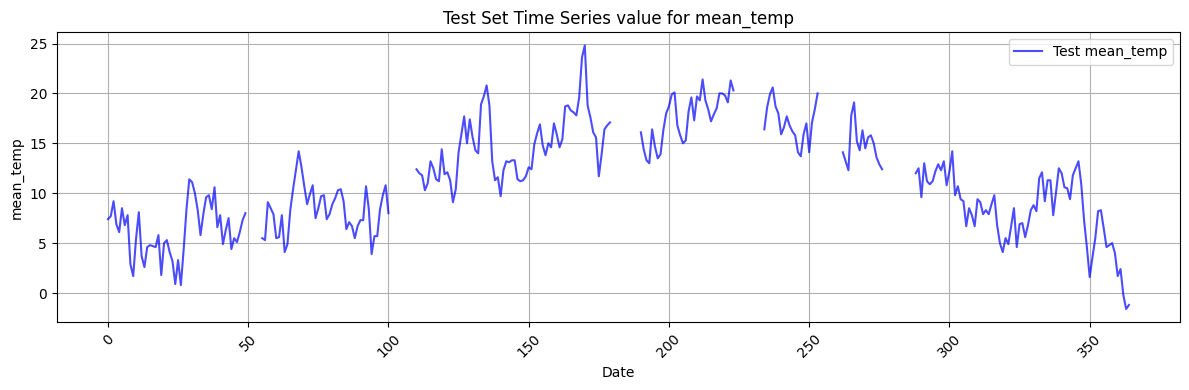

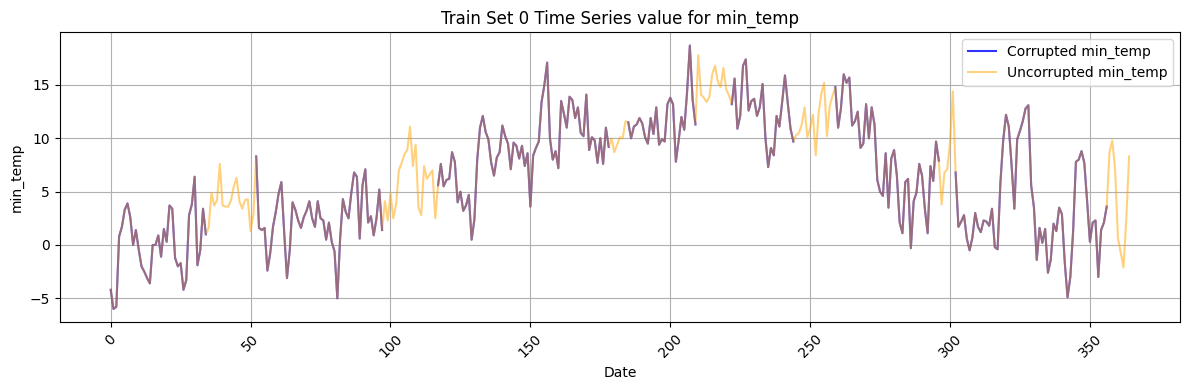

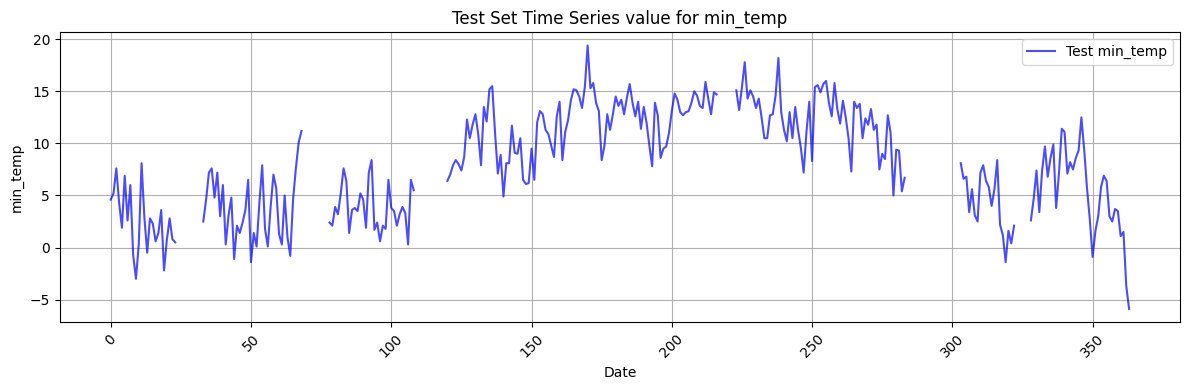

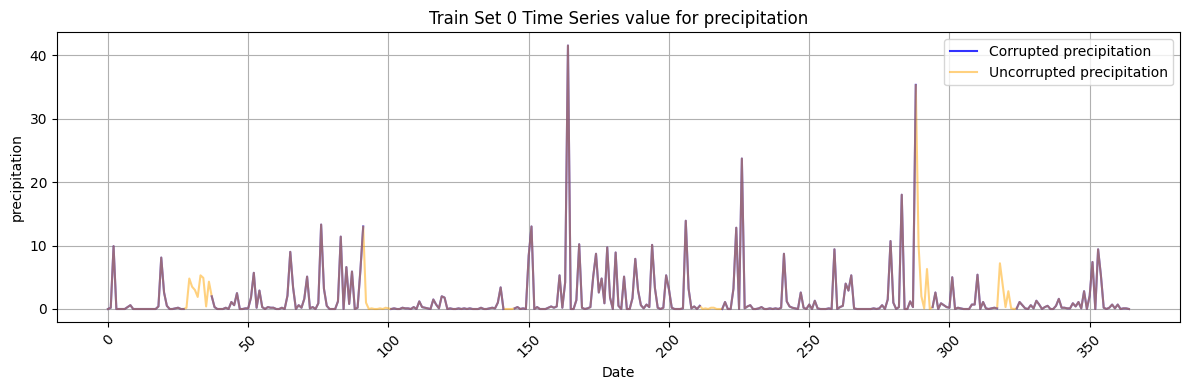

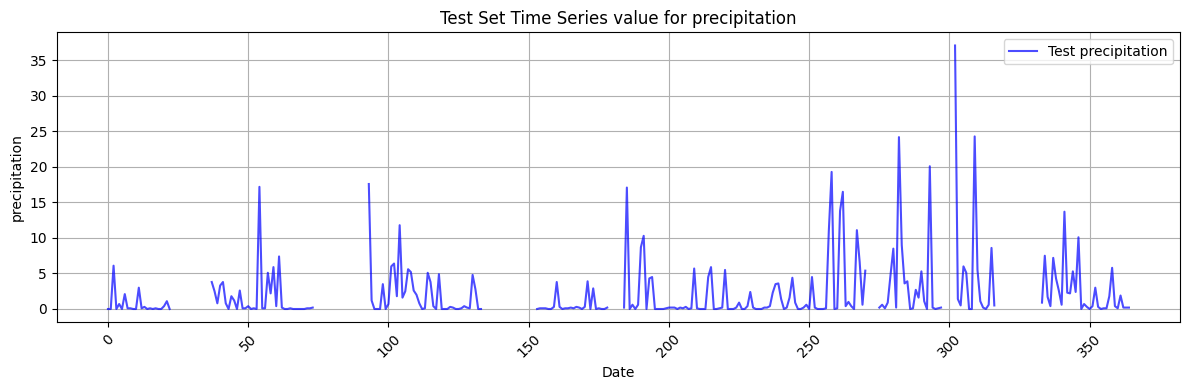

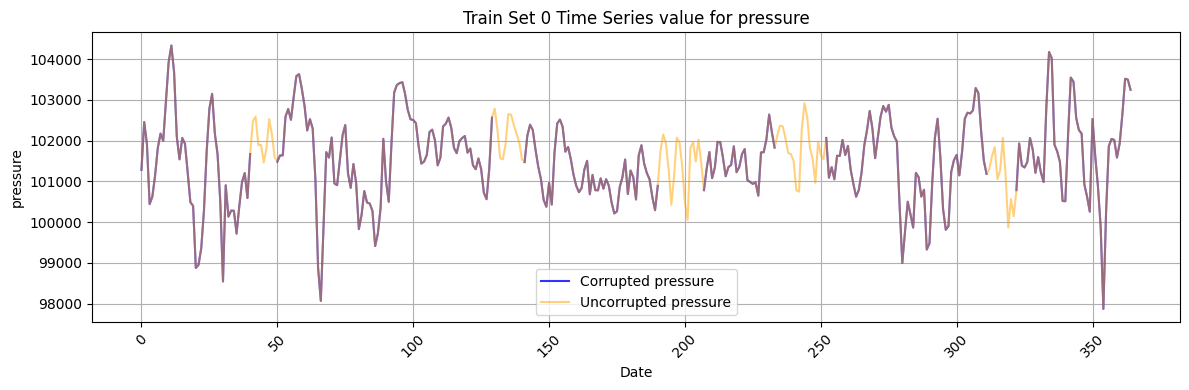

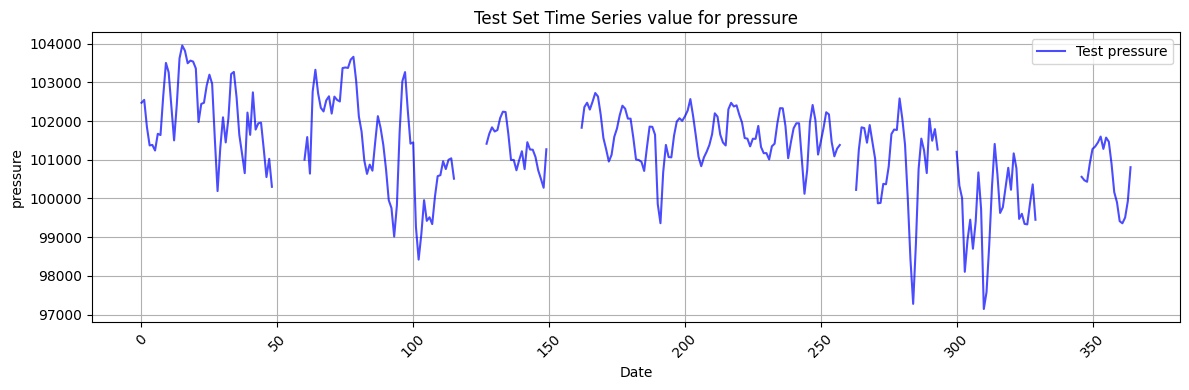

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# define variables name
variables = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure']
for i, var in enumerate(variables):
    plt.figure(figsize=(12, 4))

    # plot corrupted images for first 365 days
    plt.plot(df0['date'].iloc[:365], df0[var].iloc[:365], label=f'Corrupted {var}', color='blue', alpha=0.8, linestyle='-', markersize=4)

    # plot uncorrupted images for first 365 days
    plt.plot(df0_nogaps['date'].iloc[:365], df0_nogaps[var].iloc[:365], label=f'Uncorrupted {var}', color='orange', alpha=0.5, linestyle='-', markersize=4)

    # set up train set plot title and labels
    plt.title(f'Train Set 0 Time Series value for {var}')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    # set up test set plot title and labels
    plt.figure(figsize=(12, 4))
    plt.plot(df_test['date'].iloc[:365], df_test[var].iloc[:365], label=f'Test {var}', color='blue',alpha=0.7, linestyle='-')
    plt.title(f'Test Set Time Series value for {var}')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### **Histograms for all decades**

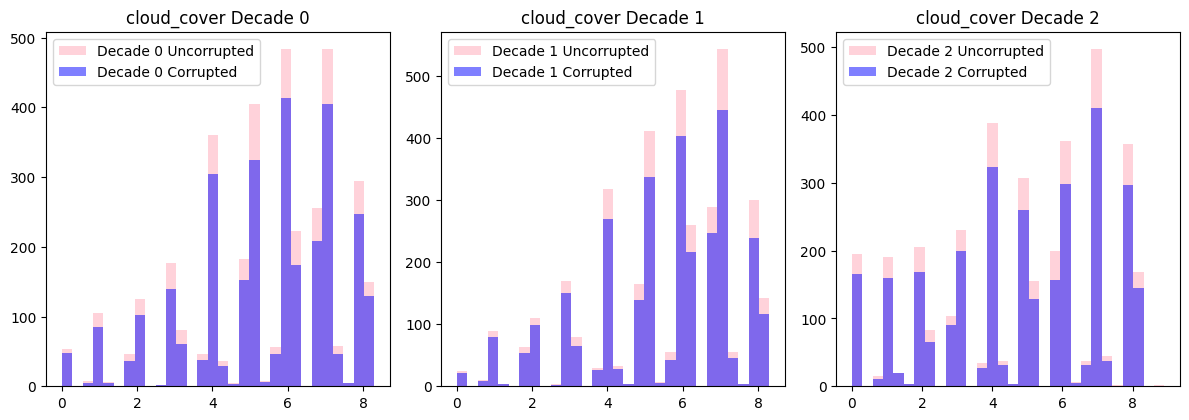

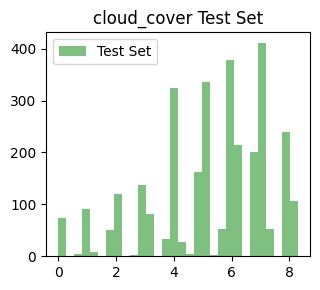

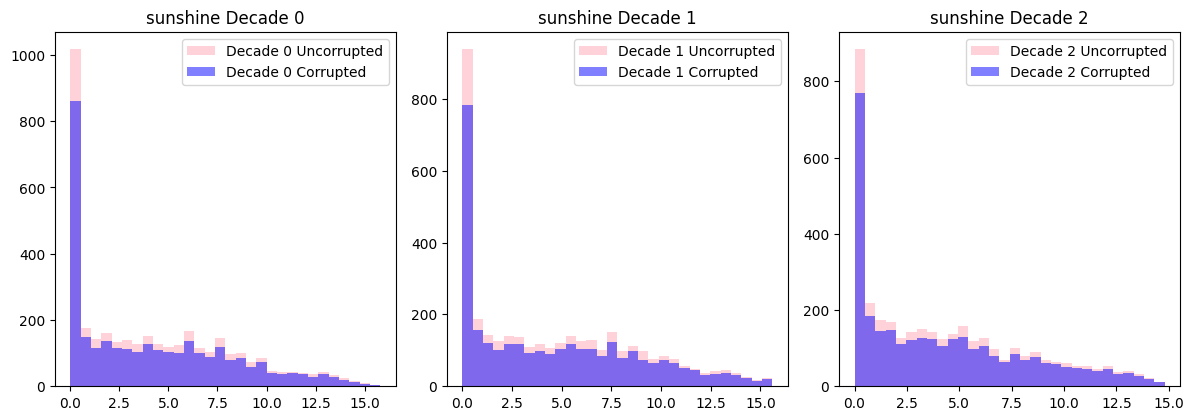

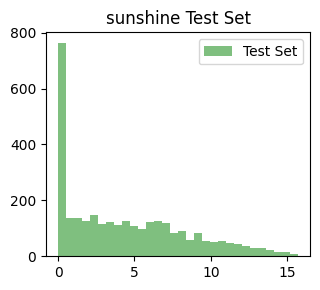

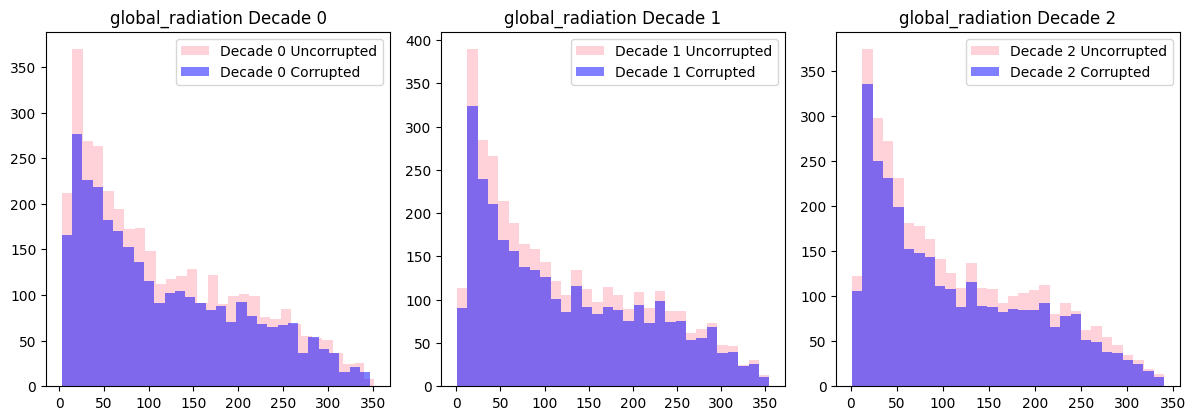

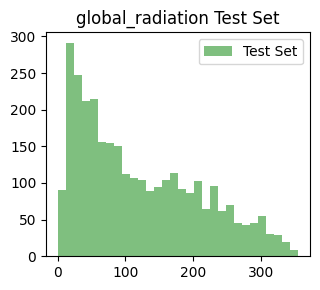

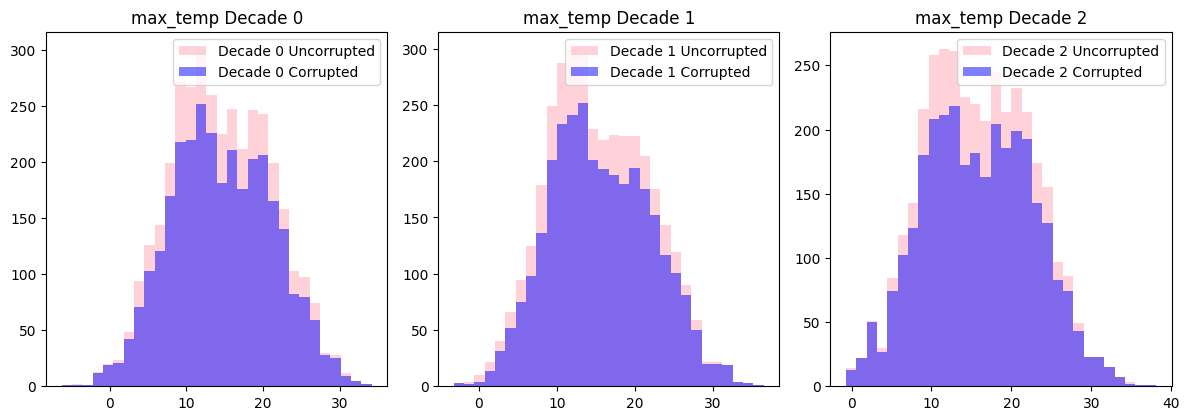

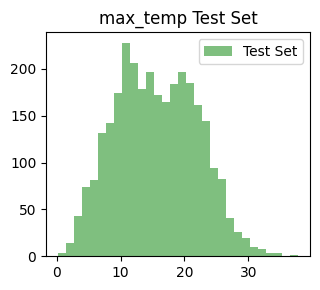

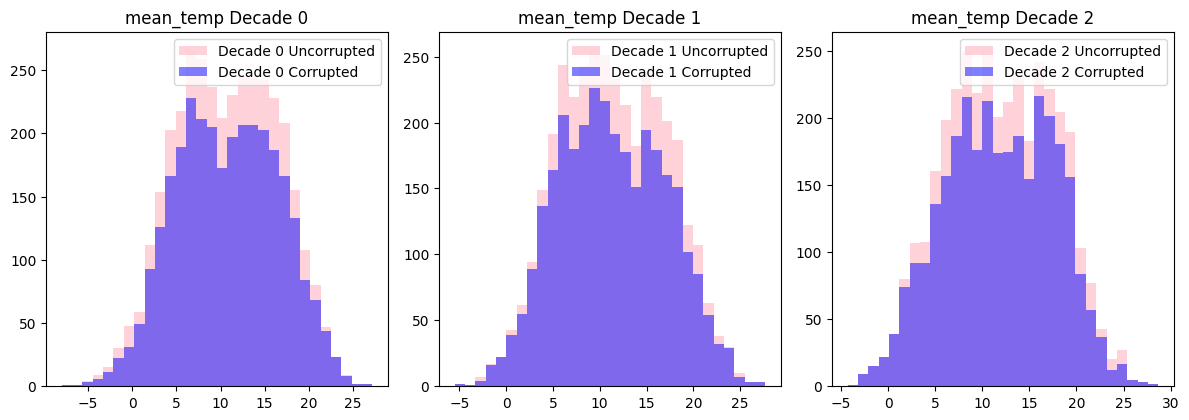

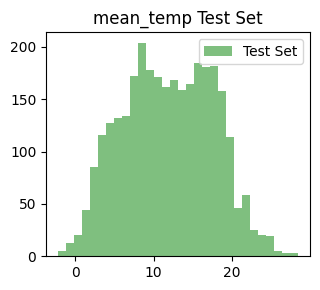

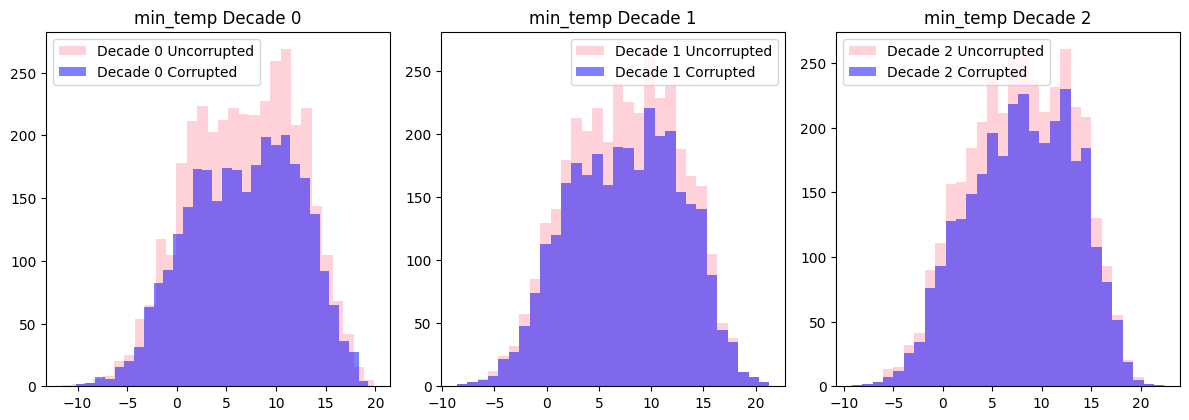

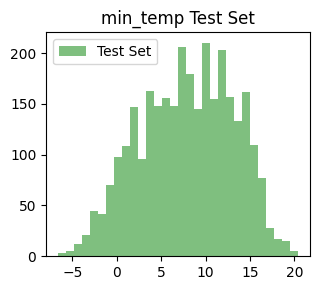

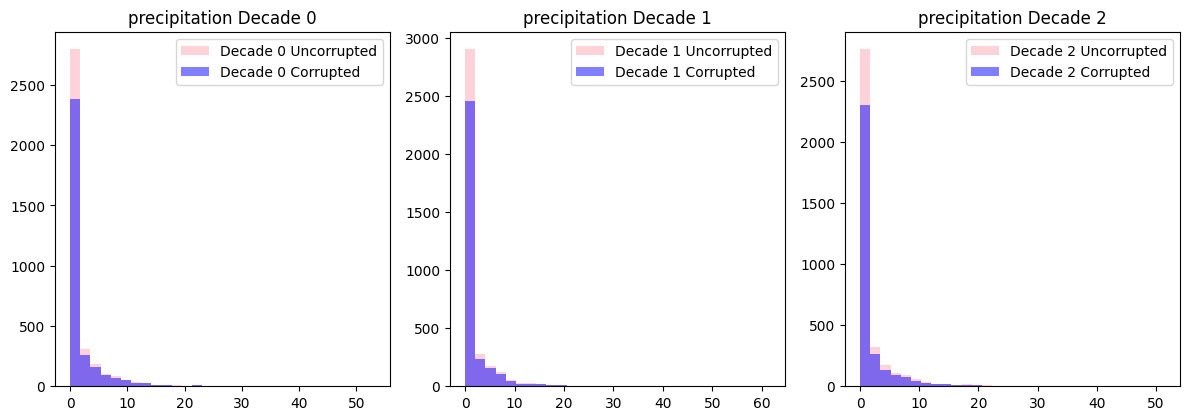

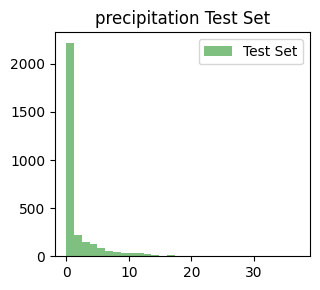

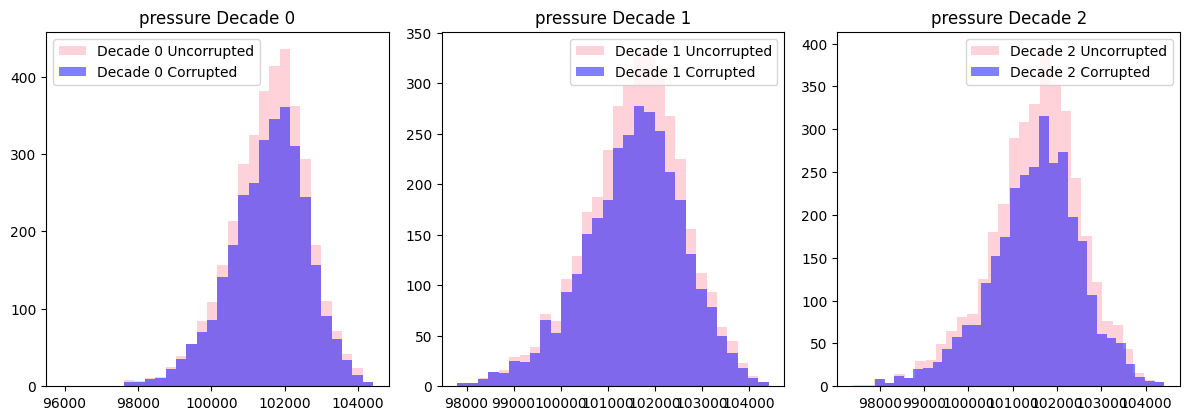

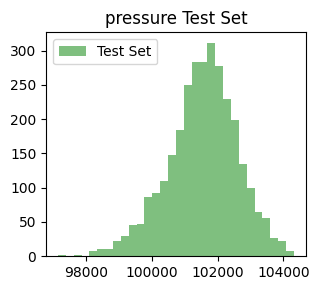

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


# list variable names
variables = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure']

# iterate variables to plot histogram
for var in variables:

    # set up train set plot title and labels
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.hist(df0_nogaps[var], bins=30, color='pink',alpha=0.7,label='Decade 0 Uncorrupted')
    plt.hist(df0[var].dropna(), bins=30, alpha=0.5, color='blue',label='Decade 0 Corrupted')
    plt.title(f'{var} Decade 0')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.hist(df1_nogaps[var], bins=30, alpha=0.7,color='pink',label='Decade 1 Uncorrupted')
    plt.hist(df1[var].dropna(), bins=30, alpha=0.5, color='blue',label='Decade 1 Corrupted')
    plt.title(f'{var} Decade 1')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.hist(df2_nogaps[var], bins=30, alpha=0.7,color='pink',label='Decade 2 Uncorrupted')
    plt.hist(df2[var].dropna(), bins=30, alpha=0.5, color='blue',label='Decade 2 Corrupted')
    plt.title(f'{var} Decade 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # set up test set plot title and labels
    plt.figure(figsize=(3.3, 3))
    plt.hist(df_test[var].dropna(), bins=30, alpha=0.5, color='green', label='Test Set')
    plt.title(f'{var} Test Set')
    plt.legend()
    plt.tight_layout()
    plt.show()


We can observe that there is left skewness in cloud_cover, right skewness in global_radiation, so I will implement MinMaxScaler on it.

Sunshine, percipitation have extreme values at beginning, so I use RobustScaler to adjust.

For max_temp, mean_temp, min_temp and pressure, they follow the standard Gaussian distribution,so I use StandardScaler.

Also, we can see the obvious gap between corrupted training data and uncorrupted training data.

## Step 2: Data Preparation and Batching

In this stage, I converted the preloaded datasets into PyTorch-compatible formats to support model training and inference.

First, I constructed a `TensorDataset` for the training data. Each sample in this dataset consists of:

- A corrupted weather sequence (model input)
- The corresponding uncorrupted sequence (supervised target)

This structure allows the model to learn how to reconstruct missing values using paired ground-truth data.

For the test dataset, since no uncorrupted version is available, I created a separate `TensorDataset` containing only corrupted sequences. This dataset is used purely for inference after the model has been trained.

I then defined two `DataLoader` objects:

- The **training DataLoader** returns batches containing both corrupted inputs and their paired uncorrupted labels.
- The **test DataLoader** returns batches of corrupted data only, without labels.

To verify that batching and pairing were correctly implemented, I visualised one batch from each loader:

- For the training batch, I plotted the corrupted input and its corresponding uncorrupted label in separate axis windows to clearly show the corruption effect.
- For the test batch, I plotted the corrupted input sequence alone.

These visual checks confirm that temporal ordering is preserved within batches and that corruption patterns are properly reflected in the training inputs.

### Load dataset

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt


# delete data columns and get variables name from df0
variables = df0.columns[1:]

# Concate three decades data to increase volumn of training dataset
df_train_corrupted = pd.concat([df0, df1, df2])
df_train_nogaps = pd.concat([df0_nogaps, df1_nogaps, df2_nogaps])


# transfer to PyTorch tensor
train_corrupted = torch.tensor(df_train_corrupted.iloc[:, 1:].values, dtype=torch.float32)
train_nogaps = torch.tensor(df_train_nogaps.iloc[:, 1:].values, dtype=torch.float32)
test_corrupted = torch.tensor(df_test.iloc[:, 1:].values, dtype=torch.float32)


# create TensorDataset
train_dataset = TensorDataset(train_corrupted, train_nogaps)
test_dataset = TensorDataset(test_corrupted)
# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



### Visualisation

Plotting Training and Test Data


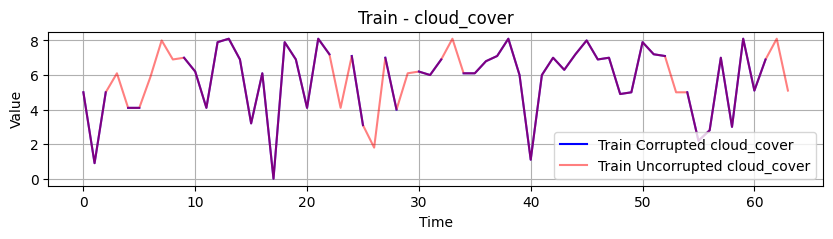

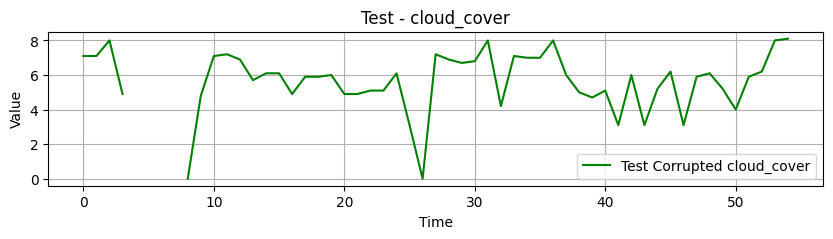

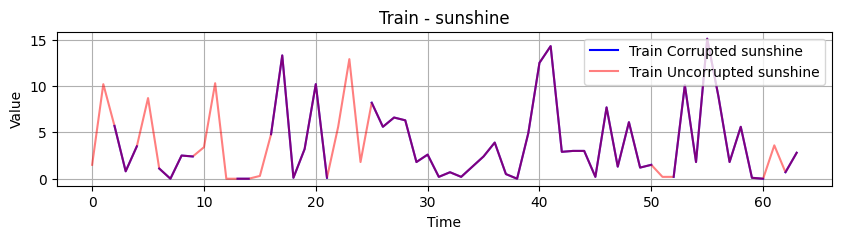

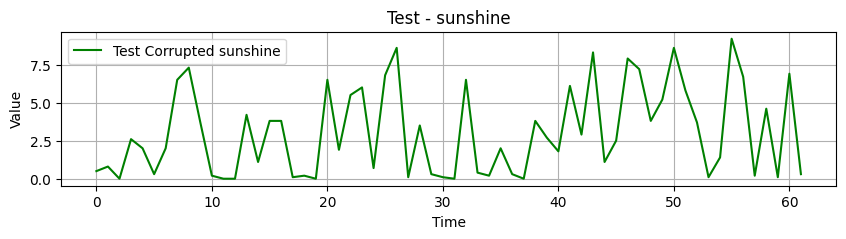

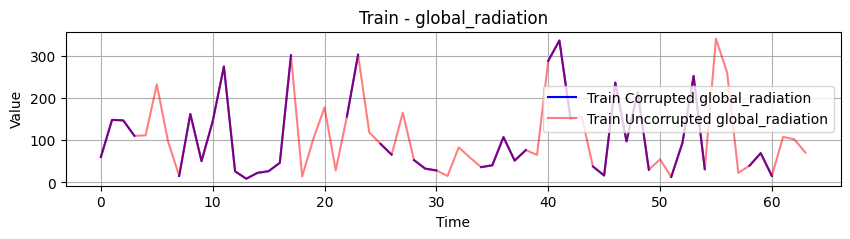

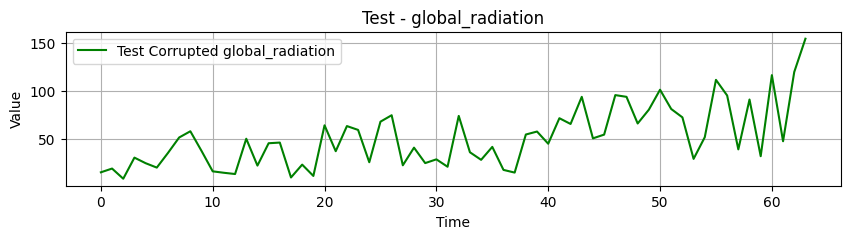

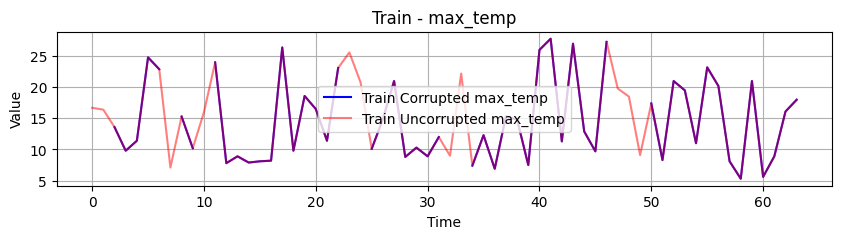

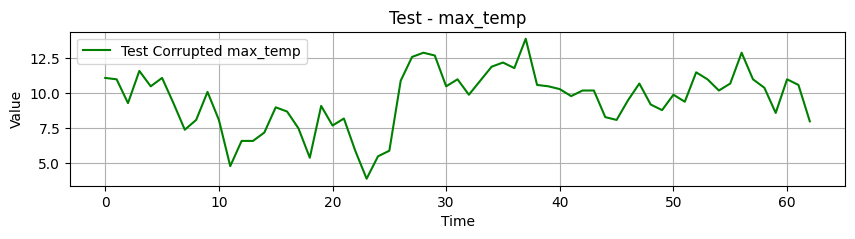

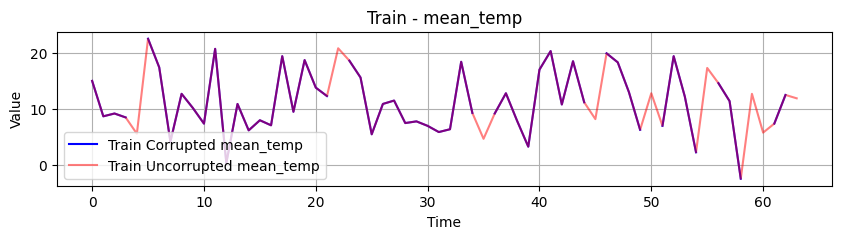

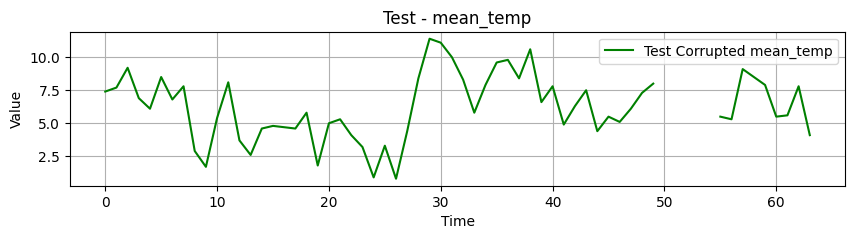

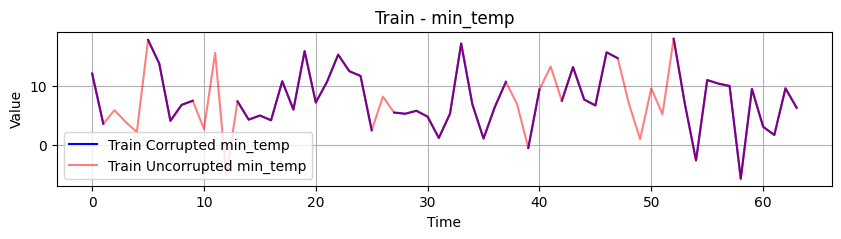

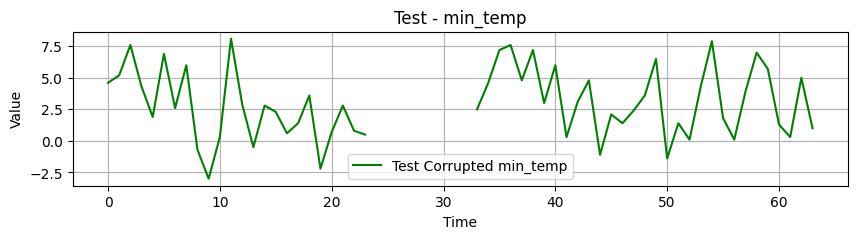

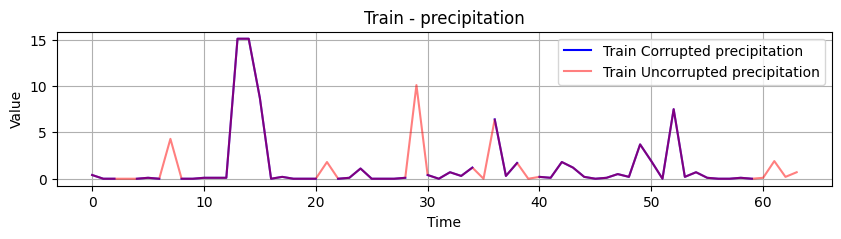

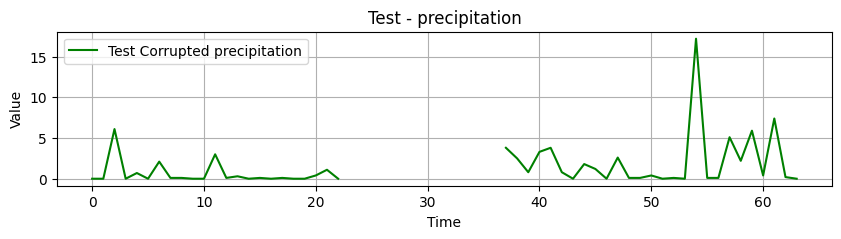

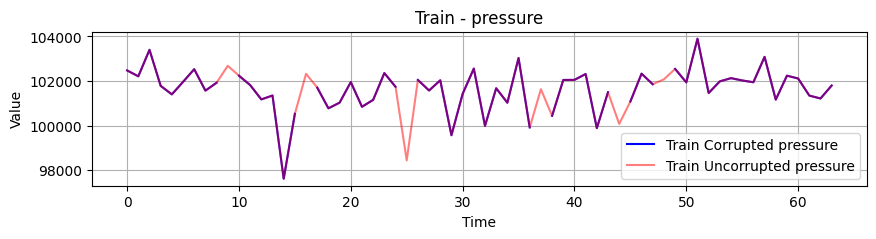

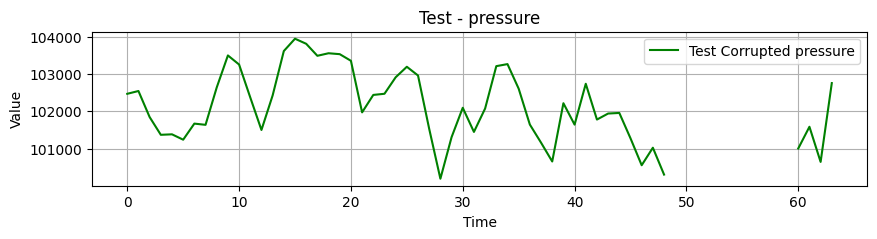

In [8]:
def plot_data(train_loader, test_loader, variables):
    # get the first batch from training set
    for batch in train_loader:
        train_data = batch[0]
        train_labels = batch[1]
        break

    # get the first batch from training set
    for batch in test_loader:
        test_data = batch[0]
        break

    # iterate variables index to plot
    for idx, var in enumerate(variables):
        # train set plot
        plt.figure(figsize=(10, 2))
        plt.plot(train_data[:, idx].numpy(), label=f'Train Corrupted {var}', color='blue', linestyle='-')
        plt.plot(train_labels[:, idx].numpy(), label=f'Train Uncorrupted {var}', color='red', alpha=0.5, linestyle='-')
        plt.title(f'Train - {var}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # test set plot
        plt.figure(figsize=(10, 2))
        plt.plot(test_data[:, idx].numpy(), label=f'Test Corrupted {var}', color='green', linestyle='-')
        plt.title(f'Test - {var}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


print("Plotting Training and Test Data")
plot_data(train_loader, test_loader, variables)


## Step 3: Model Design, Training, and Test-Set Imputation

In this step, I used the `TensorDataset` and `DataLoader` objects created in **step 2** to design and train a neural network that imputes missing daily weather measurements. The model is trained in a supervised manner using the training decades, where each input sequence contains corrupted values and each target sequence contains the corresponding uncorrupted ground truth.

After training, I applied the model to the corrupted `test_set.csv` data to generate predictions for the missing entries. I then constructed an imputed version of the test dataset by filling only the missing values with the model outputs while keeping all originally observed values unchanged. To validate the qualitative behaviour of the imputation, I plotted the resulting test time series using line plots, highlighting the filled-in values in a different colour to clearly distinguish model predictions from observed measurements.

Finally, I exported the completed test dataset to a file named `test_set_nogaps.csv`. The saved file preserves the exact format of the original `test_set.csv`, including the same column headings, row count, column ordering, and chronological row ordering, with the only difference being that missing values have been replaced by the model’s reconstructed estimates.

### Architecture Summary (to be completed with your final model)
I selected a sequence model suitable for multivariate time-series imputation, designed to capture both (i) temporal dependencies across days and (ii) cross-variable relationships between weather measurements. Key design choices included the use of a missingness mask (to explicitly indicate gaps), feature normalisation for stable optimisation, and a loss function computed primarily over missing entries to focus learning on reconstruction performance. I tuned important hyperparameters such as sequence length, hidden dimension, number of layers, learning rate, batch size, and regularisation (e.g., dropout / weight decay) based on validation performance on held-out segments of the training decades.

### Sources
I referenced external resources for implementation details and modelling ideas, including official PyTorch documentation and general time-series imputation literature. I also used ChatGPT to help draft and refine parts of the code structure and explanation, and I cite it here as a development tool used during the assessment.

### RNN

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim

class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WeatherRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)  # RNN layer
        self.fc = nn.Linear(hidden_size, hidden_size)  # Fully connected layer
        self.norm = nn.LayerNorm(hidden_size)  # Layer normalization

    def forward(self, x):
        x, hidden = self.rnn(x)
        # Apply layer normalization
        x = self.norm(x)
        # Residual connection: skip connection from input to the output of the RNN layer
        residual = self.fc(x)
        x = self.fc(x)
        # Add the residual (skip connection)
        x += residual
        return x



def train_variable_model(data_loader, variable_idx, epochs=10):
    # initialise model
    input_size = 1
    hidden_size = 50
    output_size = 1

    model = WeatherRNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-6)

    # train model
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            data, targets = batch

            # fill in the missing value as 0 first
            data[torch.isnan(data)] = 0
            data[torch.isinf(data)] = 0
            targets[torch.isnan(targets)] = 0
            targets[torch.isinf(targets)] = 0

            if data.dim() == 2:
                data = data.unsqueeze(1)
            if targets.dim() == 2:
                targets = targets.unsqueeze(1)

            data = data[:, :, variable_idx].unsqueeze(-1)
            targets = targets[:,:, variable_idx].unsqueeze(-1)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()

            # gradient crop to avoid gradient exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}')

    return model

# train model for each variable
models = []
for i in range(len(variables)):
    print(f'Training model for {variables[i]}')
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    model = train_variable_model(loader, i, epochs=10)
    models.append(model)


Training model for cloud_cover


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 35.59928793948871
Epoch 2, Loss: 35.24288222532578
Epoch 3, Loss: 34.91665601591327
Epoch 4, Loss: 34.58235852433363
Epoch 5, Loss: 34.19423901304907
Epoch 6, Loss: 33.87118461875804
Epoch 7, Loss: 33.525322160637415
Epoch 8, Loss: 33.20915764900408
Epoch 9, Loss: 32.858555874393566
Epoch 10, Loss: 32.52684990796681
Training model for sunshine
Epoch 1, Loss: 37.19339820594899
Epoch 2, Loss: 36.98274332719364
Epoch 3, Loss: 36.66183015139388
Epoch 4, Loss: 36.458153716329235
Epoch 5, Loss: 36.153184651633396
Epoch 6, Loss: 35.8681998127751
Epoch 7, Loss: 35.65787420467455
Epoch 8, Loss: 35.43697104162099
Epoch 9, Loss: 35.09494343026386
Epoch 10, Loss: 34.86601206165013
Training model for global_radiation
Epoch 1, Loss: 21739.478339103498
Epoch 2, Loss: 21694.430851972484
Epoch 3, Loss: 21721.287630398143
Epoch 4, Loss: 21698.679072521867
Epoch 5, Loss: 21720.093974922558
Epoch 6, Loss: 21671.259233213375
Epoch 7, Loss: 21674.95162456724
Epoch 8, Loss: 21648.663063160533


I use the simple RNN first to impute missing value of training data. At first, loss is nan value, I realise I need to fill in the missing value in corrupted data, so I add 0 first. I know it may confuse machine with real 0 value and fillin 0 value, so I adjust this problem in lSTM model. After the revise, the loss is huge, so I try to use LSTM combined with Automatic Encoder to capture long time dependencies as weather data is highly time-dependent. And encoder decoder allow model to recover spatial information between sequences. But it not works. So I try to add gradient crop and decrease learning rate to avoid gradient exploding and loss decrease a little bit.

### LSTM

Epoch 1/100, Train Loss: 1.216329, Val Loss: 1.014997
Epoch 2/100, Train Loss: 0.997912, Val Loss: 0.786169
Epoch 3/100, Train Loss: 0.767054, Val Loss: 0.987996
Epoch 4/100, Train Loss: 0.975261, Val Loss: 0.660314
Epoch 5/100, Train Loss: 0.645030, Val Loss: 0.658842
Epoch 6/100, Train Loss: 0.641191, Val Loss: 0.634157
Epoch 7/100, Train Loss: 0.614657, Val Loss: 0.588027
Epoch 8/100, Train Loss: 0.567140, Val Loss: 0.529511
Epoch 9/100, Train Loss: 0.508152, Val Loss: 0.468312
Epoch 10/100, Train Loss: 0.448068, Val Loss: 0.409793
Epoch 11/100, Train Loss: 0.391823, Val Loss: 0.355953
Epoch 12/100, Train Loss: 0.341123, Val Loss: 0.312774
Epoch 13/100, Train Loss: 0.301852, Val Loss: 0.280261
Epoch 14/100, Train Loss: 0.272665, Val Loss: 0.251240
Epoch 15/100, Train Loss: 0.246284, Val Loss: 0.222777
Epoch 16/100, Train Loss: 0.220162, Val Loss: 0.198162
Epoch 17/100, Train Loss: 0.197486, Val Loss: 0.179441
Epoch 18/100, Train Loss: 0.180240, Val Loss: 0.165573
Epoch 19/100, Train

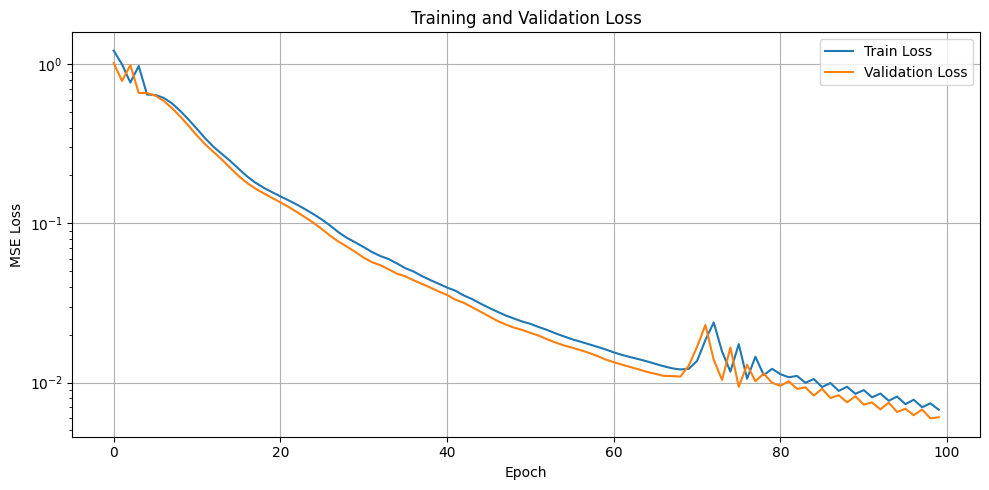

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt




# check for nan location
nan_mask = df_test.isna()
# fill in nan with mean value of training set temperary
train_corrupted_filled = df_train_corrupted.fillna(df_train_corrupted.mean())
# fill in nan with mean value of test set temperary
df_test_filled = df_test.copy().fillna(df_test.mean())



standard_features = ['max_temp', 'mean_temp', 'min_temp', 'pressure']
robust_features = ['sunshine', 'precipitation']
minmax_features = ['cloud_cover', 'global_radiation']

# initialise scaler
std_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# fit scaler
std_scaler.fit(train_corrupted_filled[standard_features])
robust_scaler.fit(train_corrupted_filled[robust_features])
minmax_scaler.fit(train_corrupted_filled[minmax_features])

# get variable names
features_order = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure']

# scale the training set
train_scaled = np.zeros((len(train_corrupted_filled), len(features_order)), dtype=float)

# transform minmax_features
train_minmax_data = minmax_scaler.transform(train_corrupted_filled[minmax_features])
train_scaled[:, features_order.index('cloud_cover')] = train_minmax_data[:, minmax_features.index('cloud_cover')]
train_scaled[:, features_order.index('global_radiation')] = train_minmax_data[:, minmax_features.index('global_radiation')]

# transform robust_features
train_robust_data = robust_scaler.transform(train_corrupted_filled[robust_features])
train_scaled[:, features_order.index('sunshine')] = train_robust_data[:, robust_features.index('sunshine')]
train_scaled[:, features_order.index('precipitation')] = train_robust_data[:, robust_features.index('precipitation')]

# transform standard_features
train_standard_data = std_scaler.transform(train_corrupted_filled[standard_features])
train_scaled[:, features_order.index('max_temp')] = train_standard_data[:, standard_features.index('max_temp')]
train_scaled[:, features_order.index('mean_temp')] = train_standard_data[:, standard_features.index('mean_temp')]
train_scaled[:, features_order.index('min_temp')] = train_standard_data[:, standard_features.index('min_temp')]
train_scaled[:, features_order.index('pressure')] = train_standard_data[:, standard_features.index('pressure')]

# Scaling the test set
test_scaled = np.zeros((len(df_test_filled), len(features_order)), dtype=float)

test_minmax_data = minmax_scaler.transform(df_test_filled[minmax_features])
test_scaled[:, features_order.index('cloud_cover')] = test_minmax_data[:, minmax_features.index('cloud_cover')]
test_scaled[:, features_order.index('global_radiation')] = test_minmax_data[:, minmax_features.index('global_radiation')]

test_robust_data = robust_scaler.transform(df_test_filled[robust_features])
test_scaled[:, features_order.index('sunshine')] = test_robust_data[:, robust_features.index('sunshine')]
test_scaled[:, features_order.index('precipitation')] = test_robust_data[:, robust_features.index('precipitation')]

test_standard_data = std_scaler.transform(df_test_filled[standard_features])
test_scaled[:, features_order.index('max_temp')] = test_standard_data[:, standard_features.index('max_temp')]
test_scaled[:, features_order.index('mean_temp')] = test_standard_data[:, standard_features.index('mean_temp')]
test_scaled[:, features_order.index('min_temp')] = test_standard_data[:, standard_features.index('min_temp')]
test_scaled[:, features_order.index('pressure')] = test_standard_data[:, standard_features.index('pressure')]



# transfer data to Pytorch Tensor
corrupted_tensor = torch.tensor(train_scaled, dtype=torch.float32).unsqueeze(0)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).unsqueeze(0)



# Model validation
seq_length = corrupted_tensor.shape[1]
train_size = int(seq_length * 0.8)
val_size = seq_length - train_size

train_data = corrupted_tensor[:, :train_size, :]
val_data = corrupted_tensor[:, train_size:, :]

train_dataset = TensorDataset(train_data, train_data)
val_dataset = TensorDataset(val_data, val_data)
test_dataset = TensorDataset(test_tensor)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# create LSTM architecture
class FillMissingValuesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(FillMissingValuesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out

# initiate LSTM model
hidden_size = 128
num_layers = 1
input_size = corrupted_tensor.shape[2]
model = FillMissingValuesLSTM(input_size, hidden_size, num_layers)

# define loss function and optimiser
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# model training
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    # training process
    model.train()
    running_loss = 0.0
    for corrupted_batch, target_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(corrupted_batch)
        loss = criterion(predictions, target_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation process
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_batch, val_target in val_loader:
            val_preds = model(val_batch)
            val_loss = criterion(val_preds, val_target)
            val_running_loss += val_loss.item()
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# plot loss curve for training set and validation set
plt.figure(figsize=(10,5))
# use log transform to y axis
plt.yscale('log')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Use trained model to predict nan value and fill in
model.eval()
with torch.no_grad():
    predictions = model(test_tensor).squeeze(0).numpy() # (seq_length, features)


# prepare index
cloud_cover_idx = features_order.index('cloud_cover')
sunshine_idx = features_order.index('sunshine')
global_radiation_idx = features_order.index('global_radiation')
max_temp_idx = features_order.index('max_temp')
mean_temp_idx = features_order.index('mean_temp')
min_temp_idx = features_order.index('min_temp')
precipitation_idx = features_order.index('precipitation')
pressure_idx = features_order.index('pressure')


pred_minmax = predictions[:, [cloud_cover_idx, global_radiation_idx]]

# robust_features = ['sunshine', 'precipitation']
pred_robust = predictions[:, [sunshine_idx, precipitation_idx]]

# standard_features = ['max_temp', 'mean_temp', 'min_temp', 'pressure']
pred_std = predictions[:, [max_temp_idx, mean_temp_idx, min_temp_idx, pressure_idx]]

# inverse transform
orig_minmax = minmax_scaler.inverse_transform(pred_minmax)
orig_robust = robust_scaler.inverse_transform(pred_robust)
orig_std = std_scaler.inverse_transform(pred_std)

# Remove the corresponding column from the result of the inverse transformation
cloud_cover_data = orig_minmax[:, [0]]
global_radiation_data = orig_minmax[:, [1]]

sunshine_data = orig_robust[:, [0]]
precipitation_data = orig_robust[:, [1]]

max_temp_data = orig_std[:, [0]]
mean_temp_data = orig_std[:, [1]]
min_temp_data = orig_std[:, [2]]
pressure_data = orig_std[:, [3]]

# splice back togetherClick to apply
filled_data = np.hstack([
    cloud_cover_data,
    sunshine_data,
    global_radiation_data,
    max_temp_data,
    mean_temp_data,
    min_temp_data,
    precipitation_data,
    pressure_data
])



#Transform to DataFrame
filled_df = pd.DataFrame(filled_data, columns=df_test.columns[1:])

# keep the same data type
for col in filled_df.columns:
    filled_df[col] = filled_df[col].astype(df_test[col].dtype)

# fill in nan value
for col in filled_df.columns:
    filled_df.loc[nan_mask[col], col] = filled_df.loc[nan_mask[col], col]
    filled_df.loc[~nan_mask[col], col] = df_test.loc[~nan_mask[col], col]

# fill in the complete dataframe
filled_df['date'] = df_test['date']
filled_df = filled_df[['date'] + [col for col in filled_df.columns if col != 'date']]

# save value as CSV
filled_df.to_csv('/content/drive/MyDrive/DL_HW2/test_set_nogaps.csv', index=False)


From the validation loss function, we can see the model is still a little underfitting and unstable, but overall perforance is good, achieving 0.006 loss in 100 epoch.

In model training and decrease loss, I apply different scaler method in different varibles for data preprocessing. I also tried for encoder decoder method, but make it worse.

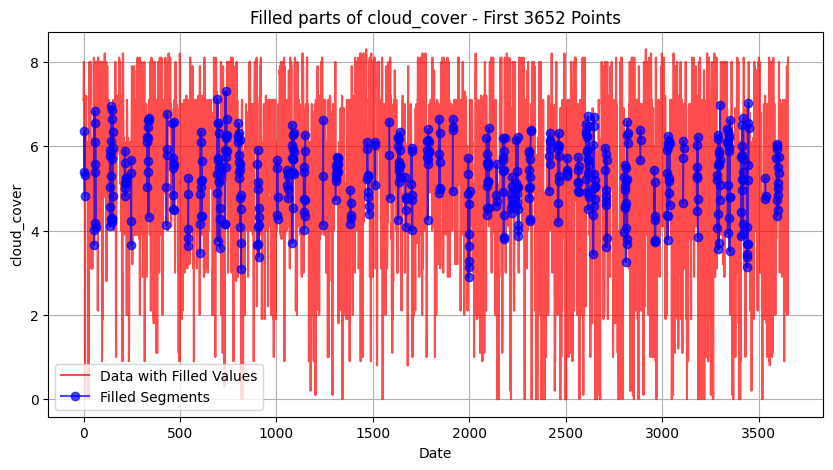

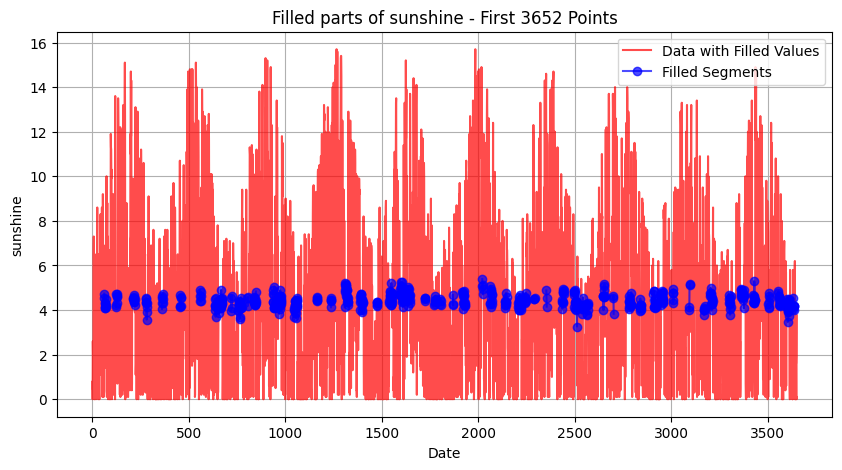

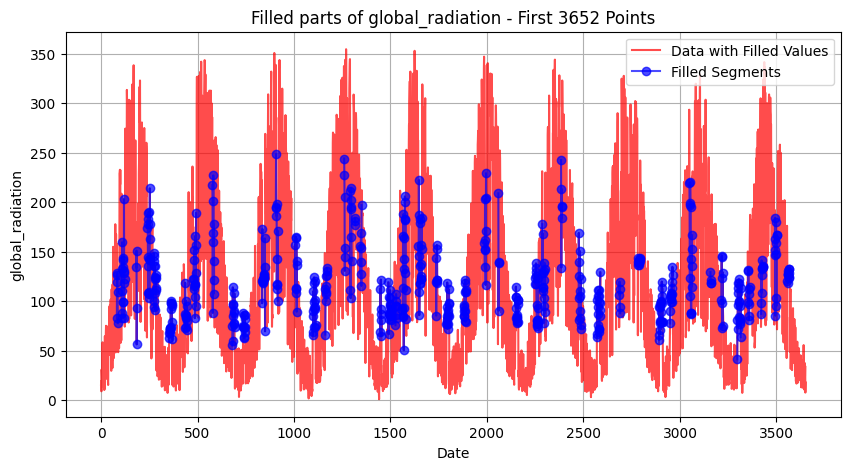

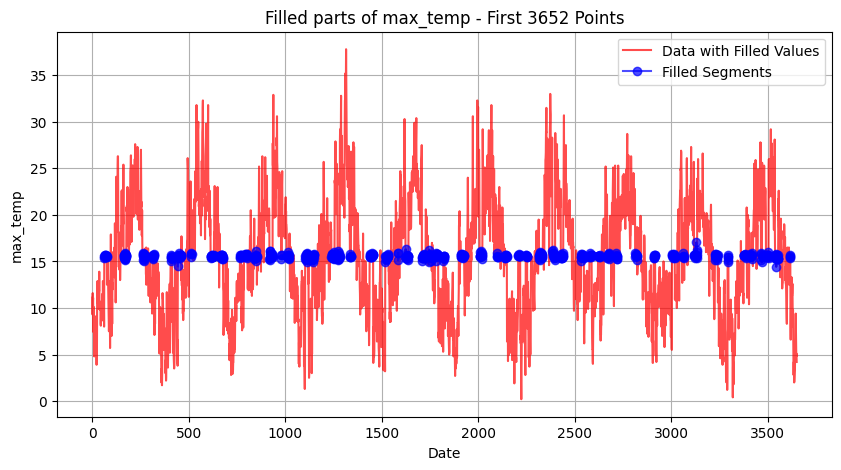

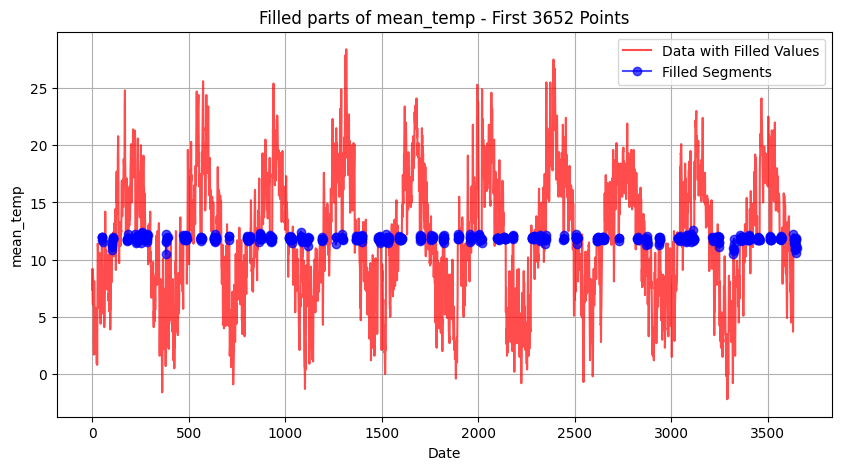

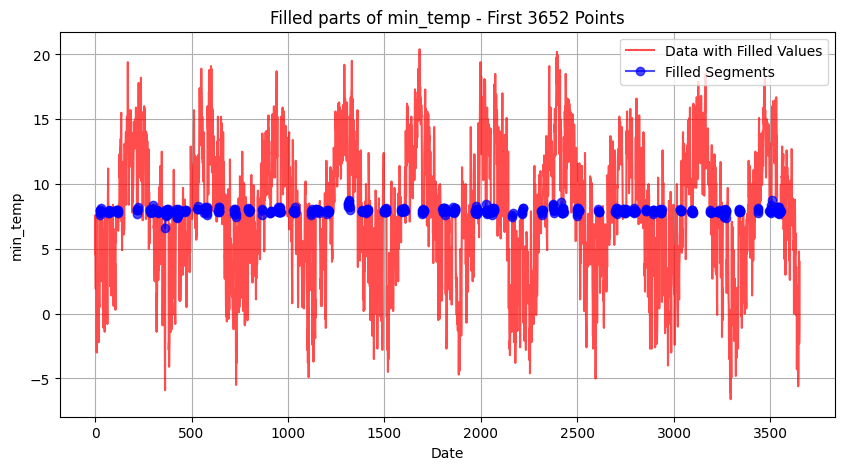

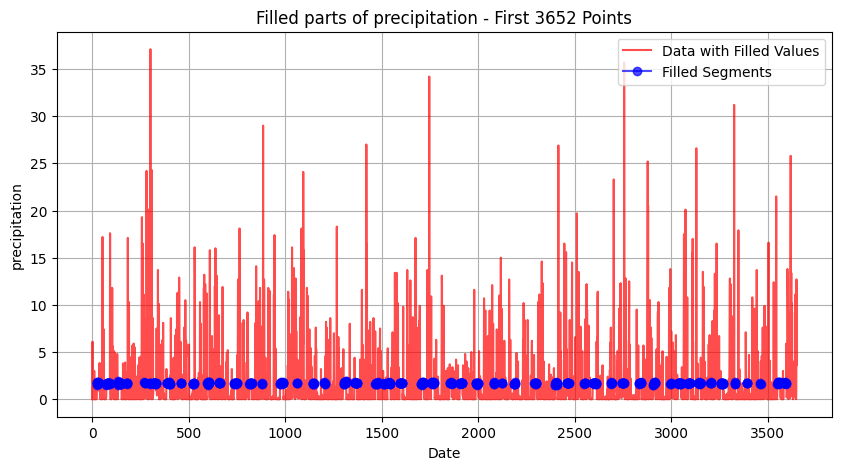

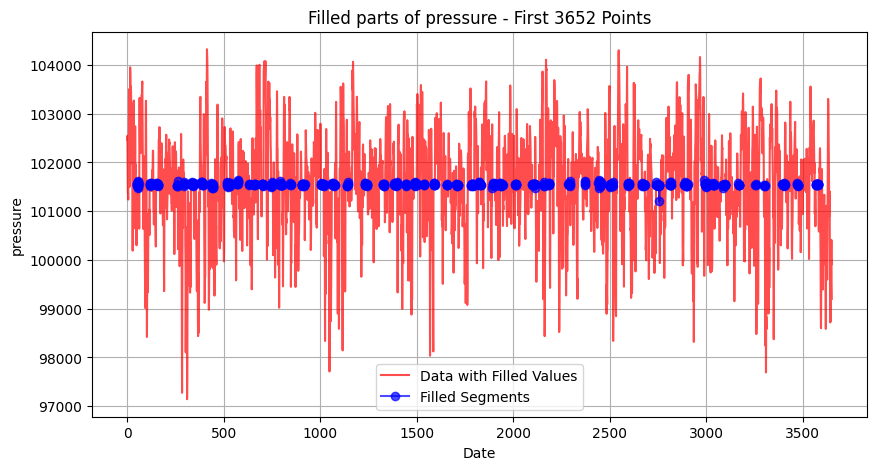

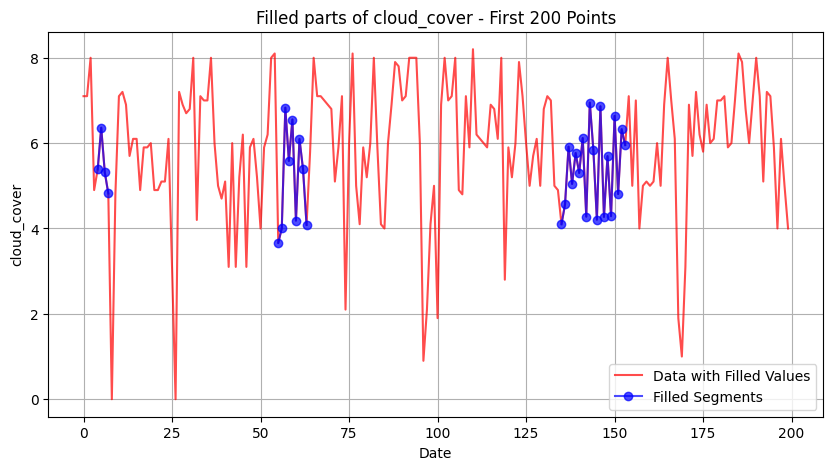

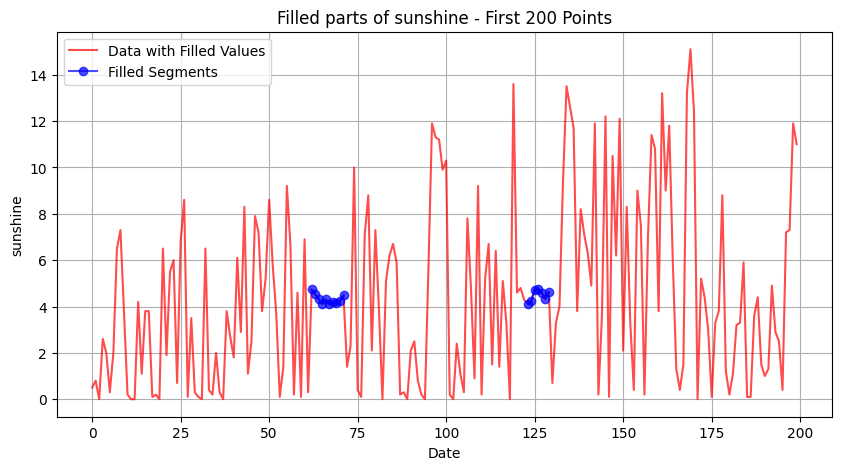

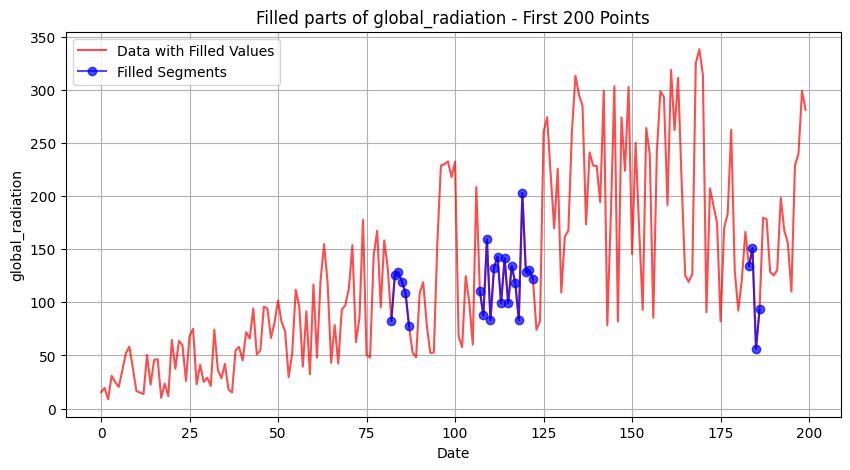

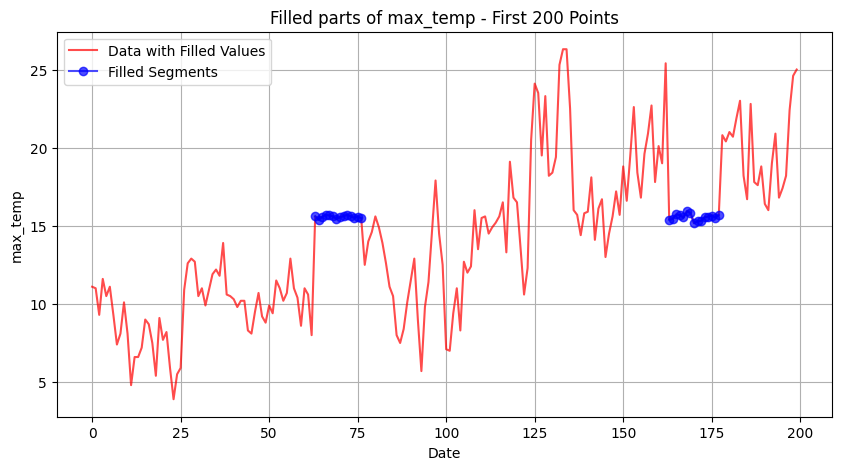

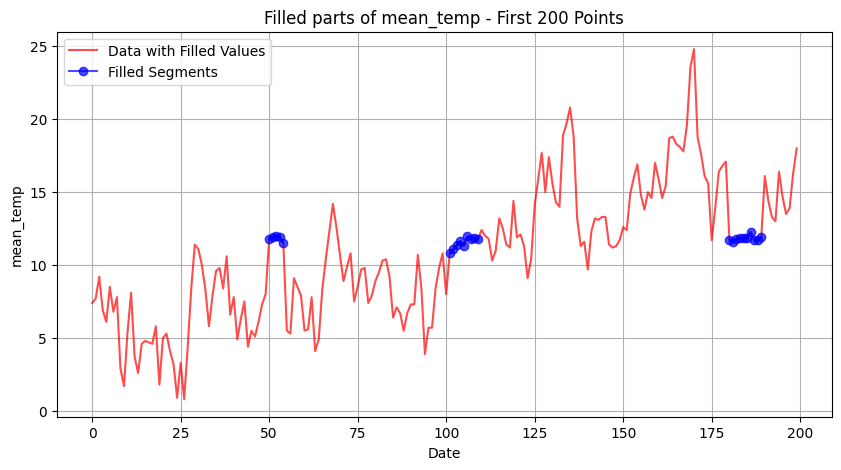

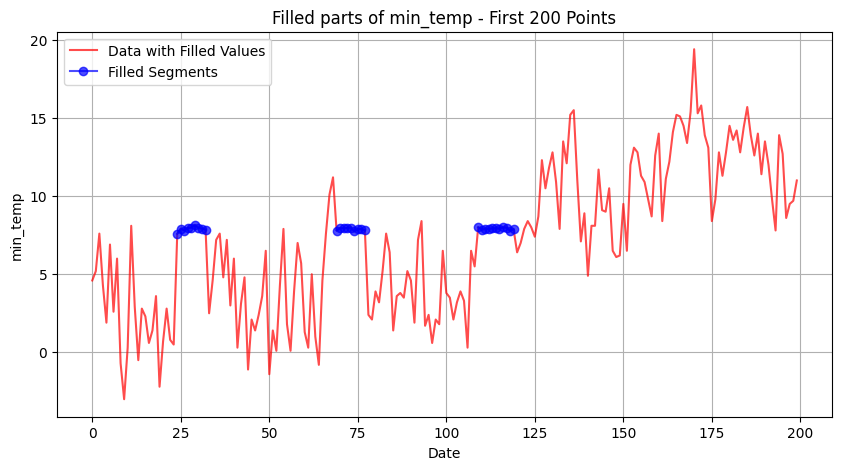

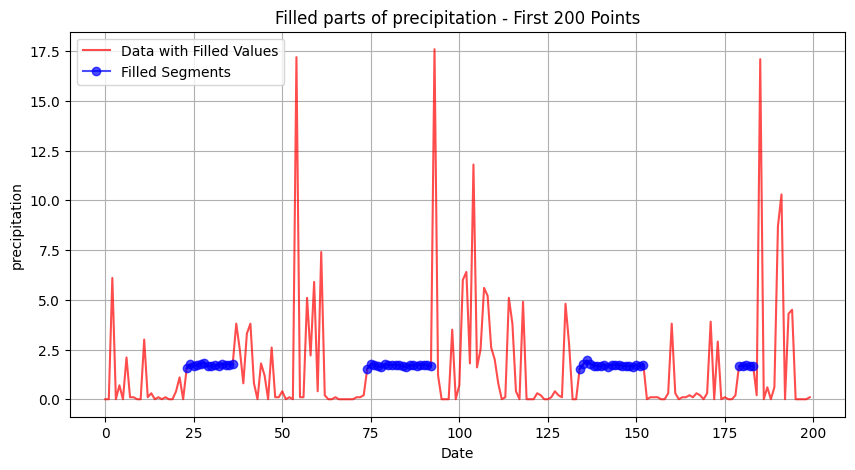

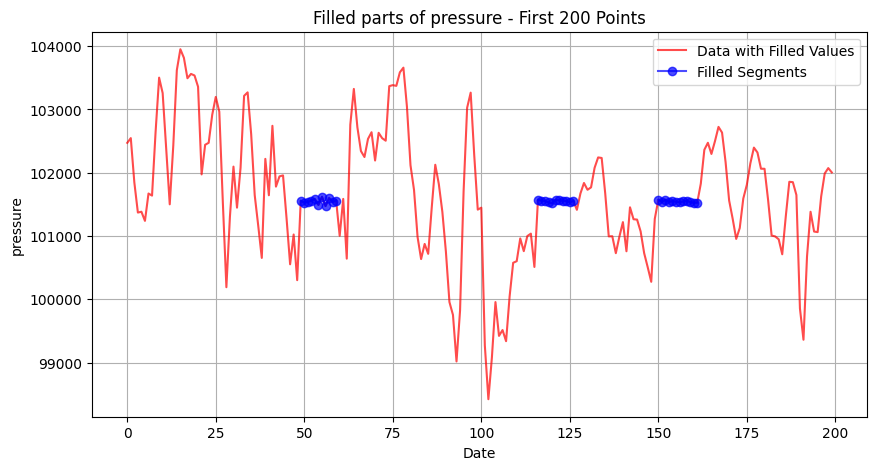

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_filled_segments(df_test, filled_df, limit):
    """
    Compare the original test data with the filled data within the given first LIMIT number of data points and plot the missing values in segments.

    parameter：
    df_test: Raw test data with date column and other variable columns
    filled_df: Equally sized data boxes with missing values filled in
    limit: Range of the first number of data points to be plotted
    """

    for column in filled_df.columns:
        if column != 'date':
            plt.figure(figsize=(10, 5))
            plt.title(f'Filled parts of {column} - First {limit} Points')

            # get boolean value of nan value
            nan_indices = df_test[column].isna()

            # fill in missing values
            plot_data = df_test[column].copy()
            plot_data[nan_indices] = filled_df[column][nan_indices]

            # plot corrupted test data
            plt.plot(df_test['date'][:limit], plot_data[:limit], label='Data with Filled Values', color='red', alpha=0.7, linestyle='-')


            mask = nan_indices & (df_test.index < limit)
            missing_indices = df_test.index[mask]

            # Split in segmentation of missing values
            if len(missing_indices) > 0:
                mis_ind_arr = missing_indices.to_numpy()
                diff = np.diff(mis_ind_arr)
                split_points = np.where(diff != 1)[0] + 1
                segments = np.split(mis_ind_arr, split_points)

                first_segment = True
                for seg in segments:
                    if first_segment:
                        plt.plot(df_test['date'][seg], plot_data[seg],
                                 label='Filled Segments', color='blue', marker='o', alpha=0.7, linestyle='-')
                        first_segment = False
                    else:
                        plt.plot(df_test['date'][seg], plot_data[seg],
                                 color='blue', marker='o', alpha=0.7, linestyle='-')

            # plot graph
            plt.legend()
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.grid(True)
            plt.show()

# plot for whole test set
plot_filled_segments(df_test, filled_df, limit=3652)
# zoom in to see first 300 days values
plot_filled_segments(df_test, filled_df, limit=200)


For visualisation of imputed test set, I insulation the plot code to make it a function for sustainability. I plot the whole test set with all variables, and also to zoom in with first 200 days data to see clearly the performance of LSTM model, and use segmented lines to show the whole trend clearly.